In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier


In [4]:
# before getting into modeling, we need to do some feature engineering. Looking at 
# the relationship between different features and the labels

# splitting the whole dataset into 7:2:1
# with different parameter combinations, train the classifier on 70% of the data
# get the performance metrics on the 20% of the data
# perform a grid search for the optimal combination of parameters for the classifiers
# once found the best combination of parameters, use them to train model on 90% of the data
# fit on the rest 10% and calculate the test metrics. 

In [5]:
final = pd.read_csv("final.csv", 
                             names = ['case' ,'platform', 'customer_id', 'timeStamp',
                                      'matched_payment_complete', 'label', 'name', 'email', 'gender', 'age',
                                      'home_type', 'square_footage', 'number_of_bedrooms', 'number_of_floors',
                                      'household', 'platform_y', 'street', 'suburb'])

final['times_denid']=final.groupby('customer_id')['label'].cumsum()

# final["first_half_email"] = final.email.map(lambda x: x.split("@")[0])
# final["name_in_email"] = 1*(final['first_half_email'] == final["name"])
# del final['first_half_email']

final.head()

,case,platform,customer_id,timeStamp,matched_payment_complete,label,name,email,gender,age,home_type,square_footage,number_of_bedrooms,number_of_floors,household,platform_y,street,suburb,times_denid
0,90527688b31d445,mobile_browser,99ccf1,1.483194e+09,1,1,Nicole Berry,Nicole Berry@hotmail.com,male,29,1,311.803620,2,1,"[{'name': 'Oscar Berry', 'age': 25, 'gender': ...",mobile_browser,66 Lake Jamieview,PSC,1
1,4c9ab2942b484f2,pc_browser,9bae09,1.483197e+09,1,0,Brandi Harris,Brandi Harris@duncan.com,male,62,1,523.432957,2,1,"[{'name': 'Michael Harris', 'age': 12, 'gender...",pc_browser,60 West Lisaside,Jamie Port Suite,0
2,cf1d5d9af6d54ef,pc_browser,b7aab4,1.483201e+09,1,1,Christopher Moody,Christopher Moody@green.info,male,40,1,221.633267,3,1,[],pc_browser,120 Danielmouth,Unit Box,1
3,ae3f3d4c667a455,pc_browser,2bc68b,1.483205e+09,1,1,Loretta Steele,Loretta Steele@patton-smith.biz,female,48,1,301.854950,3,1,"[{'name': 'Zachary Steele', 'age': 48, 'gender...",pc_browser,73 Edwardfurt,Michelle Crossing Suite,1
4,5f4bd7c6884b4d1,mobile_browser,48802d,1.483211e+09,1,1,Taylor Ortiz,Taylor Ortiz@reyes.com,male,28,1,282.311278,2,1,"[{'name': 'Stephen Ortiz', 'age': 25, 'gender'...",mobile_browser,39 Garciahaven,Melissa Roads,1


In [6]:
final[final.customer_id =="9bae09"]
# [['label','denied_times']]

,case,platform,customer_id,timeStamp,matched_payment_complete,label,name,email,gender,age,home_type,square_footage,number_of_bedrooms,number_of_floors,household,platform_y,street,suburb,times_denid
1,4c9ab2942b484f2,pc_browser,9bae09,1.483197e+09,1,0,Brandi Harris,Brandi Harris@duncan.com,male,62,1,523.432957,2,1,"[{'name': 'Michael Harris', 'age': 12, 'gender...",pc_browser,60 West Lisaside,Jamie Port Suite,0


In [7]:
by_suburb = final[['suburb','label']].groupby("suburb").agg(['sum','count'])
by_suburb['fraud_ratio'] = by_suburb["label","sum"] / by_suburb["label","count"]
by_suburb = by_suburb.sort_values(by ='fraud_ratio' ,ascending = False)
by_suburb.head(10)

label       fraud_ratio
                        sum count            
suburb                                       
Banks Points             29   136    0.213235
Rebecca Island           27   138    0.195652
Larry View               27   148    0.182432
Connie Terrace           19   107    0.177570
Bolton Point Apt.        20   119    0.168067
Hannah Road Apt.         24   149    0.161074
Taylor Park              26   176    0.147727
Woods Trafficway Apt.    28   192    0.145833
Robert Views             25   176    0.142045
Garcia Mall              30   213    0.140845

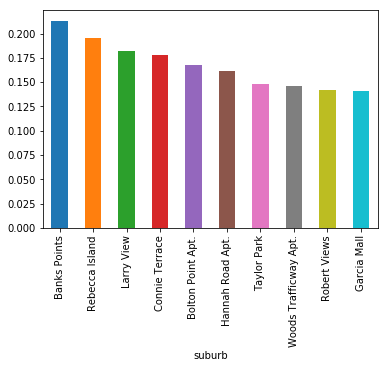

In [8]:
by_suburb.head(10).fraud_ratio.plot.bar()
plt.show()
# top 10 fradulent suburbs

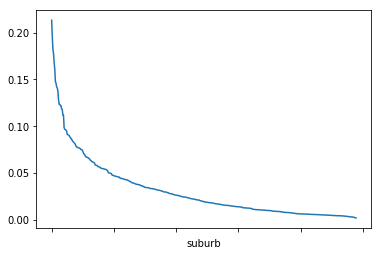

In [9]:
# some suburbs are more likely to produce frauds 
# the fraud ratio varis a lot across differen suburbs, 
# making suburb a good predictor
by_suburb.fraud_ratio.plot()

In [10]:
# then we invistigate different platforms 
by_platform = final[['platform','label']].groupby("platform").agg(['sum','count'])
by_platform['fraud_ratio'] = by_platform["label","sum"] / by_platform["label","count"]
by_platform = by_platform.sort_values(by ='fraud_ratio' ,ascending = False)
by_platform
# as we can see, claims coming from mobile apps are more
# end up being frauds, while phone calls are never fradulent 

label         fraud_ratio
                 sum   count            
platform                                
mobile_app      2066  112977    0.018287
pc_browser      5278  338839    0.015577
mobile_browser  3150  251879    0.012506
phone_call         0  120309    0.000000

In [11]:
# we can look at gender distribution as well
by_gender = final[['gender','label']].groupby("gender").agg(['sum','count'])
by_gender['fraud_ratio'] = by_gender["label","sum"] / by_gender["label","count"]
by_gender = by_gender.sort_values(by ='fraud_ratio' ,ascending = False)
by_gender
# there isn't distinct difference when it comes to gender 
# we can conduct statistical test to validate these results

label         fraud_ratio
         sum   count            
gender                          
female  5267  410077    0.012844
male    5227  413927    0.012628

In [46]:
X = final.drop("label", axis =1 )
Y = final.label

X.gender = X.gender.map({"male":1,"female":0})
le = preprocessing.LabelEncoder()
le.fit(X.suburb.unique().tolist()) # taking all the suburbs 
X.suburb = le.transform(X.suburb)

le_plat = preprocessing.LabelEncoder()
le_plat.fit(X.platform.unique().tolist()) 
X.platform = le_plat.transform(X.platform)



X=X[['matched_payment_complete','suburb','times_denid']]
# del X['platform_y']
# del X['case']
# del X['email']
# del X['street']
# del X['household']
# del X['name']
# del X['customer_id']



# categorial variables 


X.head()

,matched_payment_complete,suburb,times_denid
0,1,325,1
1,1,189,0
2,1,453,1
3,1,297,1
4,1,288,1


In [56]:
mid = int(X.shape[0]*0.2)
X_train = X[:mid]
Y_train = Y[:mid]

X_test = X[mid:]
Y_test = Y[mid:]

# randomforest 
clf = DecisionTreeClassifier(random_state=2 )
#                              ,max_features=3,max_depth=3)
clf.fit(X_train, Y_train)

pred_label = pd.Series(clf.predict(X_test))
y_test = pd.Series(Y_test.tolist())

# True Negative rate on test:  TN / N
TN = ((y_test == pred_label)&(y_test==0) ).sum()
TP = ((y_test == pred_label)&(y_test==1) ).sum()

TNR = TN / (len(Y_test)- Y_test.sum())
TPR = TP/ Y_test.sum()

FP = ((y_test != pred_label)&(y_test==0) ).sum()
print("False Positives: {:.5f} normal people misclassified as frauds".format(FP))

print("True Negative rate on test: {:.6f}".format(TNR))
# print("True Positives: {:.5f}".format(TP))
print("True Positive rate on test: {:.6f}".format(TPR))

False Positives: 0.00000 normal people misclassified as frauds
True Negative rate on test: 1.000000
True Positive rate on test: 1.000000


In [61]:
a= len(final[(final.matched_payment_complete==1)&(final.times_denid>0)&(final.label==1)]) 
b= len(final[(final.times_denid>0)&(final.matched_payment_complete==1)])
a/b

1.0

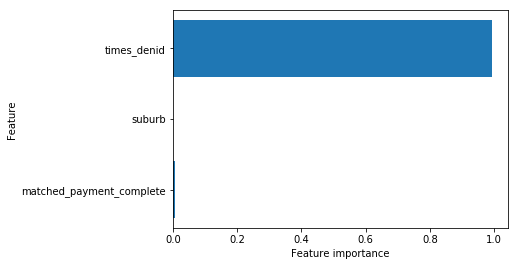

In [62]:
# for now we have only considered incoming information. We haven't taken into considertion the claim history of a customer
# need to include how many times a person got denied already
plot_feature_importances_cancer(clf)

# we found out that different generate decision trees, even when their performances are similar, have 
# really different prediction rules, favoring different features
# to overcome this bias, a natural further step is to generate a lot of trees
# and take their avg, hence random forest 

# random state 99 